## Plots for experiments in finite regime

In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import gridspec
from matplotlib.lines import Line2D
import scipy
from src import utils
import copy
import pickle

### Plotting setup

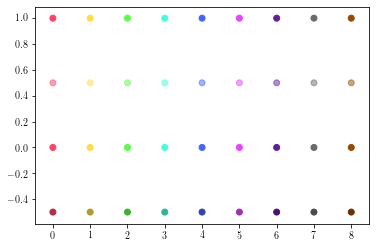

In [2]:
# Set tex formatting for plots
from matplotlib import rc
rc('font',**{'family':'serif','sans-serif':['Computer Modern Roman']})
rc('text', usetex=True)
#plt.rcParams["font.family"] = "serif"
#plt.rcParams["font.serif"] = ["Computer Modern Roman"]

# Set legend size
from matplotlib.font_manager import FontProperties
fontP = FontProperties()
fontP.set_size('medium')

# Colors
def to_rgb(H, b=1, a=1):
    RGBa = []
    for h in H:
        h = h.lstrip("#")
        RGBa.append(tuple(int(h[i:i+2], 16) / 256 * b for i in (0, 2, 4)) + (a,))
    return np.array(RGBa)

cmap = matplotlib.cm.get_cmap('tab20')
base = ["#ff4365", "#ffdd43", "#59ff43", "#43ffdd", "#4365ff", "#e943ff", "#601e9e", "#6a6a6a", "#964b00"]#np.array([cmap(i) for i in range(2,20)])
plt.scatter(np.arange(len(base)), np.ones(len(base)), c = base)
#base = [base[i] for i in [0,1,3]]
colors = to_rgb(base)
colorsa = to_rgb(base, a=0.5)
colorsb = to_rgb(base, b=0.7)
plt.scatter(np.arange(len(colors)), np.zeros(len(colors)), c = colors)
plt.scatter(np.arange(len(colors)), np.ones(len(colors))*0.5, c = colorsa)
plt.scatter(np.arange(len(colors)), np.ones(len(colors))*-0.5, c = colorsb)

### Load and process data

In [3]:
def jaccard_sim(A,B):
    A = set(A) if type(A) is not set else A
    B = set(B) if type(B) is not set else B
    return len(A & B) / len(A | B)

In [4]:
# Code to load (and possibly merge) results from several files, as experiments can be submitted to Euler in different jobs to reduce time

def load_experiments(filename):
    f = open(filename, "rb")
    results = pickle.load(f)
    return results[0], results[1::]

def merge_runs(old, new, min_merge=False):
    if len(old) == len(new) or (len(old) < len(new) and min_merge):
        for i in range(len(old)):
            old[i] += new[i].copy()
    else:
        raise Exception("Cannot merge")
    return old

def load_results(filenames):
    cases, results = load_experiments(filenames[0])
    for filename in filenames[1::]:
        print("Loading %s" % filename)
        new_cases, new_results = load_experiments(filename)
        cases += new_cases
        for k in range(len(results)):
            results[k] = merge_runs(results[k], new_results[k])
    print("\nLoaded a total of %d graphs with %d runs each" % (len(results[0][0]), len(results[0])))
    return cases, results

In [5]:
def generate_trajectories(results, cases):
    runs = len(results[0])
    N = len(results[0][0])
    P = len(results)


    no_ints = np.zeros((len(results), runs, N))
    all_trajectories = {}
    all_type1_errors = {}
    all_empty_pool_events = {}
    names = []
    for k, policy_runs in enumerate(results):
        name = policy_runs[0][0].policy
        print("Processing results for %s policy" % name, end="")
        names.append(name)
        trajectories = []
        type1_errors = []
        empty_pool_events = []
        for i,run_results in enumerate(policy_runs):
            for j, result in enumerate(run_results):
                # add final result to history of estimates
                estimates = result.estimates() + [result.estimate]
                try:
                    # checks whether truth is contained in estimates and retrieves index
                    no_ints[k, i, j] = estimates.index(cases[j].truth)
                except ValueError:
                    # if not, add max. intervention number
                    no_ints[k, i, j] = len(result.interventions())
                trajectory = list(map(lambda estimate: jaccard_sim(cases[j].truth, estimate), estimates))
                type1_error = list(map(lambda estimate: set.issubset(estimate, cases[j].truth), estimates))
                trajectories.append(trajectory)
                type1_errors.append(type1_error)
                empty_pool_events.append(result.empty_pool)
        all_trajectories[name] = trajectories
        all_type1_errors[name] = type1_errors
        all_empty_pool_events[name] = empty_pool_events
        print(" done")
    return all_trajectories, all_type1_errors, all_empty_pool_events, N, P, runs, names, no_ints

In [6]:
# Experiments to load

# Experiments with lower bound on weights of 0.5
experiments = [
["experiments/results_1588876806_runs:4_max_iter:50_random_state:0_tag:may7_G:100_k:3.0_p_min:12_p_max:12_w_min:0.5_w_max:1.0_var_min:0.0_var_max:1.0_int_min:0.0_int_max:1.0_do:False_i_mean:10_i_var:1_finite:True_n:10_alpha:0.0002.pickle"],
["experiments/results_1588869447_runs:4_max_iter:50_random_state:0_tag:may7_G:100_k:3.0_p_min:12_p_max:12_w_min:0.5_w_max:1.0_var_min:0.0_var_max:1.0_int_min:0.0_int_max:1.0_do:False_i_mean:10_i_var:1_finite:True_n:100_alpha:0.0002.pickle"],
["experiments/results_1588979619_runs:4_max_iter:50_random_state:0_tag:may7_G:100_k:3.0_p_min:12_p_max:12_w_min:0.5_w_max:1.0_var_min:0.0_var_max:1.0_int_min:0.0_int_max:1.0_do:False_i_mean:10_i_var:1_finite:True_n:1000_alpha:0.0002.pickle"]
]

# Experiments with lower bound on weights of 0.1
#experiments = [
#["experiments/results_1588879082_runs:4_max_iter:50_random_state:0_tag:may7s_G:100_k:3.0_p_min:12_p_max:12_w_min:0.01_w_max:1.0_var_min:0.0_var_max:1.0_int_min:0.0_int_max:1.0_do:False_i_mean:10_i_var:1_finite:True_n:10_alpha:0.0002.pickle"],
#["experiments/results_1588872998_runs:4_max_iter:50_random_state:0_tag:may7s_G:100_k:3.0_p_min:12_p_max:12_w_min:0.01_w_max:1.0_var_min:0.0_var_max:1.0_int_min:0.0_int_max:1.0_do:False_i_mean:10_i_var:1_finite:True_n:100_alpha:0.0002.pickle"],
#["experiments/results_1588991306_runs:4_max_iter:50_random_state:0_tag:may7s_G:100_k:3.0_p_min:12_p_max:12_w_min:0.01_w_max:1.0_var_min:0.0_var_max:1.0_int_min:0.0_int_max:1.0_do:False_i_mean:10_i_var:1_finite:True_n:1000_alpha:0.0002.pickle"]
#]

In [7]:
def process_experiments(experiments):
    Trajectories = []
    Type1Errors = []
    NoInts = []
    EmptyPoolEvents = []
    
    for i,filenames in enumerate(experiments):
        print("\n\n %d/%d" % (i+1, len(experiments)), end=" ")
        cases, results = load_results(filenames)
        trajectories, type1_errors, empty_pool_events, N, P, runs, names, no_ints = generate_trajectories(results, cases)
        if i==0:
            prev_N, prev_P, prev_runs = N, P, runs
        elif prev_N != N or prev_P != P or prev_runs != runs:
            print(N, P, runs)
            print(prev_N, prev_P, prev_runs)
            print("Experiments have different number of graphs / policies / runs")
        Trajectories.append(trajectories)
        Type1Errors.append(type1_errors)
        NoInts.append(no_ints)
        EmptyPoolEvents.append(empty_pool_events)
    return Trajectories, Type1Errors, NoInts, EmptyPoolEvents, N, P, runs, names, cases

In [8]:
Trajectories, Type1Errors, NoInts, EmptyPoolEvents, N, P, runs, names, cases = process_experiments(experiments)



 1/3 
Loaded a total of 100 graphs with 4 runs each
Processing results for random policy done
Processing results for e policy done
Processing results for r policy done
Processing results for e + r policy done
Processing results for markov policy done
Processing results for markov + e policy done
Processing results for markov + r policy done
Processing results for markov + e + r policy done


 2/3 
Loaded a total of 100 graphs with 4 runs each
Processing results for random policy done
Processing results for e policy done
Processing results for r policy done
Processing results for e + r policy done
Processing results for markov policy done
Processing results for markov + e policy done
Processing results for markov + r policy done
Processing results for markov + e + r policy done


 3/3 
Loaded a total of 100 graphs with 4 runs each
Processing results for random policy done
Processing results for e policy done
Processing results for r policy done
Processing results for e + r policy done

**Summary of graphs used**

100 graphs in total


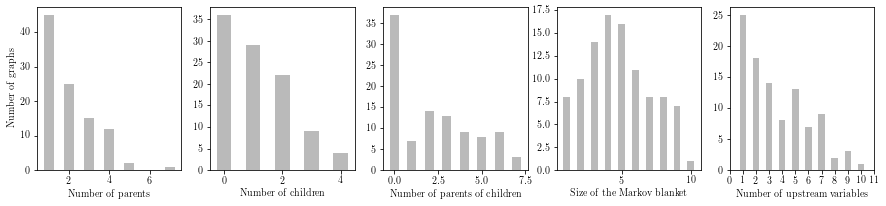

In [9]:
n_parents = np.zeros(N)
n_children = np.zeros(N)
n_poc = np.zeros(N)
n_upstream = np.zeros(N)
size_mb = np.zeros(N)
for i, case in enumerate(cases):
    parents, children, poc, mb = utils.graph_info(case.target, case.sem.W)
    ancestors = utils.ancestors(case.target, case.sem.W)
    n_parents[i] = len(parents)
    n_children[i] = len(children)
    n_poc[i] = len(poc)
    n_upstream[i] = len(ancestors)
    size_mb[i] = len(mb)

def plot_hist(data, title):
    bins = np.arange(data.min(), data.max()+2)-0.5
    hist = plt.hist(data, bins, rwidth=0.5, align='mid', color="#BABABA")#colorsb[2])
    plt.xlabel(title)
    
plt.figure(figsize=(15,3))
#plt.subplot(131), plot_hist(n_vars, "Number of variables")
plt.subplot(151), plot_hist(n_parents, "Number of parents"), plt.ylabel("Number of graphs")
plt.subplot(152), plot_hist(n_children, "Number of children")
plt.subplot(153), plot_hist(n_poc, "Number of parents of children")
plt.subplot(154), plot_hist(size_mb, "Size of the Markov blanket")
plt.subplot(155), plot_hist(n_upstream, "Number of upstream variables")
ax = plt.gca()
ax.set_xticks(range(12))

print("%d graphs in total" % N)

In [10]:
max_iter = 50

### Plot B: Comparing effects of sample size

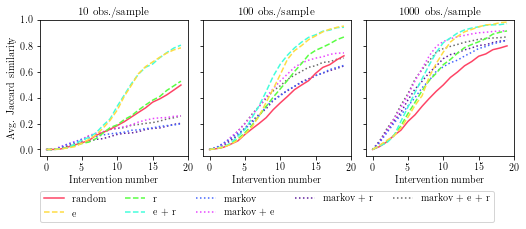

In [11]:
# Plot settings
gs = gridspec.GridSpec(1, 3, wspace=0.10, hspace=0.2)
plt.figure(figsize=(8.5,2.5))

plot_iter = 20
x_axis = np.arange(0, plot_iter)
ylim = [-0.05, 1]
linestyle = ['-', '--', '--', '--', ':', ':', ':', ':', ':']
zorder = [1,4,2,3,-1,-2,-3,-4,-5]

##############################
# Plot trajectories for n=10
jac_sim10 = np.ones((P, N*runs, max_iter+1))
for i, trajectories in enumerate(Trajectories[0].values()):
    for j, trajectory in enumerate(trajectories):
        jac_sim10[i, j, 0:len(trajectory)] = trajectory
mean10 = np.mean(jac_sim10[:, :, :], axis=1)

plt.subplot(gs[0])
ax = plt.gca()
for i,name in enumerate(names):
    ax.plot(x_axis, mean10[i,x_axis], label=name, linewidth=1.5, linestyle = linestyle[i], color=colors[i], zorder=zorder[i])
plt.xlabel("Intervention number")
plt.ylabel("Avg. Jaccard similarity")
ax.set_xticks(np.arange(0, plot_iter+1, 5))
ax.text(0.5,1.04,"10 obs./sample", transform=ax.transAxes, fontsize=11, ha="center")
plt.ylim(ylim)

##############################
# Plot trajectories for n=100
jac_sim100 = np.ones((P, N*runs, max_iter+1))
for i, (name, trajectories) in enumerate(Trajectories[1].items()):
    for j, trajectory in enumerate(trajectories):
        jac_sim100[i, j, 0:len(trajectory)] = trajectory
mean100 = np.mean(jac_sim100[:, :, :], axis=1)
plt.subplot(gs[1])
ax = plt.gca()
for i,name in enumerate(names):
    ax.plot(x_axis, mean100[i,x_axis], label=name, linewidth=1.5, linestyle = linestyle[i], color=colors[i], zorder=zorder[i])
plt.xlabel("Intervention number")
ax.set_yticklabels([])
ax.set_xticks(np.arange(0, plot_iter+1, 5))
ax.text(0.5,1.04,"100 obs./sample", transform=ax.transAxes, fontsize=11, ha="center")
plt.ylim(ylim)

##############################
# Plot trajectories for n=1000
jac_sim1000 = np.ones((P, N*runs, max_iter+1))
for i, (name, trajectories) in enumerate(Trajectories[2].items()):
    for j, trajectory in enumerate(trajectories):
        jac_sim1000[i, j, 0:len(trajectory)] = trajectory
mean1000 = np.mean(jac_sim1000[:, :, :], axis=1)

plt.subplot(gs[2])
ax = plt.gca()
for i,name in enumerate(names):
    ax.plot(x_axis, mean1000[i,x_axis], label=name, linewidth=1.5, linestyle = linestyle[i], color=colors[i], zorder=zorder[i])
plt.xlabel("Intervention number")
ax.set_yticklabels([])
ax.set_xticks(np.arange(0, plot_iter+1, 5))
ax.text(0.5,1.04,"1000 obs./sample", transform=ax.transAxes, fontsize=11, ha="center")
plt.ylim(ylim)

ax.legend(prop=fontP, ncol=5, bbox_to_anchor=(0.9, -.22))
plt.savefig('figures/jac_sim_finite.pdf', bbox_inches='tight')

#### FWER

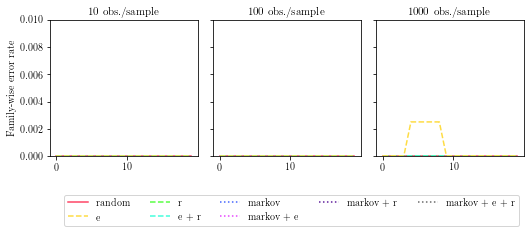

In [12]:
# Plot settings
gs = gridspec.GridSpec(1, 3, wspace=0.10, hspace=0.15)
plt.figure(figsize=(8.5,2.5))

plot_iter = 20
x_axis = np.arange(0, plot_iter)
linestyle = ['-', '--', '--', '--', ':', ':', ':', ':', ':']
zorder = [1,4,2,3,-1,-2,-3,-4,-5]

plots = zip(Type1Errors, Trajectories, [10, 100, 1000])

##############################
for i, (all_error_trajectories, jacc_trajectories, sample_size) in enumerate(plots):
    plt.subplot(gs[i])
    ax = plt.gca()
    print("Plotting %d/%d" % (i+1, len(Type1Errors)), end="\r")
    errors = np.ones((P, N*runs, max_iter+1))
    for j, (policy_trajectories, policy_jacc_trajectories) in enumerate(zip(all_error_trajectories.values(), jacc_trajectories.values())):
        for k, (trajectory, jacc_trajectory) in enumerate(zip(policy_trajectories, policy_jacc_trajectories)):
            n = min(plot_iter, len(trajectory))
            errors[j, k, 0:n] = trajectory[0:n]
#             if sum(1- errors[j, k, 0:n]) !=0:
#                 print(k)
#                 print(trajectory)
#                 print(jacc_trajectory)
#                 # case where estimate gets worse over time in terms of Jaccard sim.
    mean = np.mean(1 - errors, axis=1)
    # Plot FWER for each policy
    for j,name in enumerate(names):
        ax.plot(x_axis, mean[j,x_axis], label=name, linewidth=1.5, linestyle = linestyle[j], color=colors[j], zorder=zorder[j])    
    ax.text(0.5,1.04,"%d obs./sample" % sample_size, transform=ax.transAxes, fontsize=11, ha="center")
    ax.set_yticklabels([]) if i % 3 != 0 else None
    plt.ylim([0, 0.01])
    plt.ylabel("Family-wise error rate") if i % 3 == 0 else None
    plt.xlabel("Intervention number") if i >= 6 else None
ax.legend(prop=fontP, ncol=5, bbox_to_anchor=(1, -.25))
plt.savefig('figures/type1error_main.pdf', bbox_inches='tight')

### Plot C: Sensitivity analysis

For the next two plots (sensitivity and type-1 error) the levels on the plot have to be adjusted manually, to correspond to the `alpha` parameter from the experiments which were loaded.

In [13]:
levels = [0.025, 0.125, 0.25]

In [14]:
# Plot settings
gs = gridspec.GridSpec(3, 3, wspace=0.10, hspace=0.15)
plt.figure(figsize=(8.5,8.5))

plot_iter = 20
x_axis = np.arange(0, plot_iter)
ylim = [-0.05, 1.1]
linestyle = ['-', '--', '--', '--', ':', ':', ':', ':']
zorder = [1,4,2,3,-1,-2,-3,-4]

plots = zip([Trajectories[i] for i in [0,3,6,1,4,7,2,5,8]],
            levels * 3,
            [10] * 3 + [100] * 3 + [1000] * 3)

##############################
# Plot trajectories for n=10
for i, (all_trajectories, level, sample_size) in enumerate(plots):
    plt.subplot(gs[i])
    ax = plt.gca()
    print("Plotting %d/%d" % (i+1, len(Trajectories)), end="\r")
    jac_sim = np.ones((P, N*runs, max_iter+1))
    for j, policy_trajectories in enumerate(all_trajectories.values()):
        for k, trajectory in enumerate(policy_trajectories):
            n = min(plot_iter, len(trajectory))
            jac_sim[j, k, 0:n] = trajectory[0:n]
    mean = np.mean(jac_sim, axis=1)
    # Plot TPR for each policy
    for j,name in enumerate(names):
        ax.plot(x_axis, mean[j,x_axis], label=name, linewidth=1.5, linestyle = linestyle[j], color=colors[j], zorder=zorder[j])    
    # Labels / legend
    if i < 3:
        ax.text(0.5,1.05,"level=%s" % level, transform=ax.transAxes, fontsize=11, ha="center")
    if i % 3 == 2:
        ax.text(1.05,0.5,"%d obs./sample" % sample_size, transform=ax.transAxes, fontsize=11, va="center", rotation=90)
    ax.set_yticklabels([]) if i % 3 != 0 else None
    plt.ylim(ylim)
    plt.ylabel("Avg. Jaccard similarity") if i % 3 == 0 else None
    plt.xlabel("Intervention number") if i >= 6 else None
ax.legend(prop=fontP, ncol=5, bbox_to_anchor=(1, -.25))
plt.savefig('figures/sensitivity.pdf', bbox_inches='tight')

IndexError: list index out of range

<Figure size 612x612 with 0 Axes>

### Plot D: Type-1 error rate

In [ ]:
# Plot settings
gs = gridspec.GridSpec(3, 3, wspace=0.10, hspace=0.15)
plt.figure(figsize=(8.5,8.5))

plot_iter = 20
x_axis = np.arange(0, plot_iter)
linestyle = ['-', '--', '--', '--', ':', ':', ':', ':']
zorder = [1,4,2,3,-1,-2,-3,-4]

plots = zip([Type1Errors[i] for i in [0,3,6,1,4,7,2,5,8]],
            levels * 3,
            [10] * 3 + [100] * 3 + [1000] * 3)

##############################
# Plot trajectories for n=10
for i, (all_error_trajectories, level, sample_size) in enumerate(plots):
    plt.subplot(gs[i])
    ax = plt.gca()
    print("Plotting %d/%d" % (i+1, len(Type1Errors)), end="\r")
    errors = np.ones((P, N*runs, max_iter+1))
    for j, policy_trajectories in enumerate(all_error_trajectories.values()):
        for k, trajectory in enumerate(policy_trajectories):
            n = min(plot_iter, len(trajectory))
            errors[j, k, 0:n] = trajectory[0:n]
    mean = np.mean(1 - errors, axis=1)
    # Plot TPR for each policy
    for j,name in enumerate(names):
        ax.plot(x_axis, mean[j,x_axis], label=name, linewidth=1.5, linestyle = linestyle[j], color=colors[j], zorder=zorder[j])    
    # Labels / legend
    if i < 3:
        ax.text(0.5,1.05,"level=%s" % level, transform=ax.transAxes, fontsize=11, ha="center")
    if i % 3 == 2:
        ax.text(1.05,0.5,"%d obs./sample" % sample_size, transform=ax.transAxes, fontsize=11, va="center", rotation=90)
    ax.set_yticklabels([]) if i % 3 != 0 else None
    plt.ylim([0, 0.01])
    plt.ylabel("Type 1 error rate") if i % 3 == 0 else None
    plt.xlabel("Intervention number") if i >= 6 else None
ax.legend(prop=fontP, ncol=5, bbox_to_anchor=(1, -.25))
plt.savefig('figures/type1error.pdf', bbox_inches='tight')

## For 50 iterations

### Plots E: Number of interventions required for 50 iterations

In [ ]:
# Plotting parameters

gs = gridspec.GridSpec(3, 1, wspace=0.10, hspace=0.3)
plt.figure(figsize=(8.5,7))
dev = 0.35
xaxis = np.tile(np.arange(P), (N, 1)) - np.outer(np.linspace(-dev, dev, N), np.ones(P))
ecolor = "#cdcdcd"
markers = [".", "$2$", "^", "s", "p", "H", "$7$"]

#-----------------------------------
# Function for individual (n=x) plot

def point_plot(NoInts, ax, parents = None):
    # Plotting
    means = NoInts.mean(axis=1)
    no_parents = np.array(list(map(lambda case: len(case.truth), cases)))
    parents = range(no_parents.min(), no_parents.max() + 1) if parents is None else parents
    for p in parents:
        idx = idx = np.where(no_parents == p)[0]
        # Plot lines first
        for i in idx:            
            plt.plot(xaxis[i,:], means[:, i].T, color=ecolor, zorder=0, linewidth=0.5)
        # Plot dots
        for i in idx:
            plt.scatter(xaxis[i,:],
                        means[:, i].T,
                        marker=markers[p-1],
                        c=colors[0:P],
                        zorder=1,
                        edgecolors=colorsb)
    
    # Set labels 
    plt.ylabel("Avg. no. of interventions")
    ax.set_xticks([0,1,1.95,2.9,3.85,4.85,5.9,7.05])
    total_averages = means.mean(axis=1)
    labels = []
    for i, avg in enumerate(total_averages):
        labels.append(names[i] + "\n(%0.2f)" % avg)
    ax.set_xticklabels(labels, ha="center", rotation=0)
    

#---------------------------
# Compose all plots together

NoIntsAux = copy.deepcopy(NoInts)
for no_ints in NoIntsAux:
    no_ints[no_ints > max_iter] = max_iter

parents = None

# n=10
plt.subplot(gs[0])
ax = plt.gca()
point_plot(NoIntsAux[0], ax, parents)
ax.set_yticks([0, 10, 20, 30, 40, 50])
plt.ylim(-5, 55)
ax.text(0.01,0.027,"10 obs./sample", transform=ax.transAxes, fontsize=10, ha="left")

# n=100
plt.subplot(gs[1])
ax = plt.gca()
point_plot(NoIntsAux[1], ax, parents)
ax.set_yticks([0, 10, 20, 30, 40, 50])
plt.ylim(-5, 55)
ax.text(0.01,0.027,"100 obs./sample", transform=ax.transAxes, fontsize=10, ha="left")

# n=1000
plt.subplot(gs[2])
ax = plt.gca()
point_plot(NoIntsAux[2], ax, parents)
ax.set_yticks([0, 10, 20, 30, 40, 50])
plt.ylim(-5, 55)
ax.text(0.01,0.027,"1000 obs./sample", transform=ax.transAxes, fontsize=10, ha="left")

# Build legend
legend_elements = []
for i,m in enumerate(markers):
    legend_elements.append(Line2D([0],[0],
                                  marker=m,
                                  color=[0,0,0,0],
                                  label= '%d parent' % (i+1) + ('s' if i > 0 else ''),
                                  markerfacecolor=colorsa[7],
                                  markeredgecolor=colors[7],
                                  markersize=7))
ax.legend(handles=legend_elements,prop=fontP, ncol=5, bbox_to_anchor=(0.95, -0.25))

# Save figure
plt.savefig('figures/intervention_numbers_finite_50_iter.pdf', bbox_inches='tight')

#### Violin plot for number of interventions required

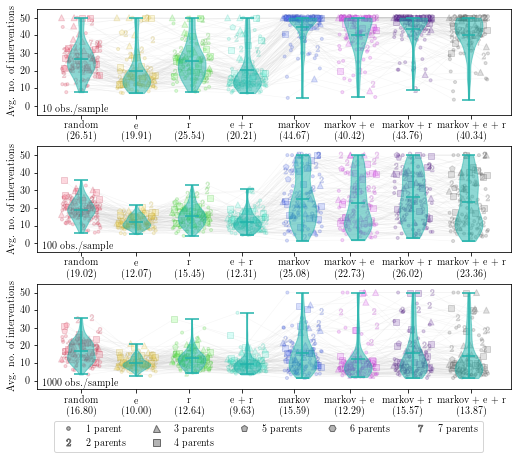

In [21]:
# Plotting parameters

gs = gridspec.GridSpec(3, 1, wspace=0.10, hspace=0.3)
plt.figure(figsize=(8.5,7))
dev = 0.35
xaxis = np.tile(np.arange(P), (N, 1)) - np.outer(np.linspace(-dev, dev, N), np.ones(P))
ecolor = "#cdcdcd"
violin_color = 'lightseagreen'
markers = [".", "$2$", "^", "s", "p", "H", "$7$"]

#-----------------------------------
# Function for individual (n=x) plot

def violin_plot(NoInts, ax, parents = None):
    # Plotting
    means = NoInts.mean(axis=1)
    no_parents = np.array(list(map(lambda case: len(case.truth), cases)))
    parents = range(no_parents.min(), no_parents.max() + 1) if parents is None else parents
    for p in parents:
        idx = idx = np.where(no_parents == p)[0]
        # Plot lines first
        for i in idx:            
            plt.plot(xaxis[i,:], means[:, i].T, color=ecolor, zorder=0, linewidth=0.5, alpha=0.2)
        # Plot dots
        for i in idx:
            plt.scatter(xaxis[i,:],
                        means[:, i].T,
                        marker=markers[p-1],
                        c=colors[0:P],
                        zorder=1,
                        edgecolors=colorsb, 
                        alpha=0.2)
    
    parts = ax.violinplot([means[i,:] for i in range(means.shape[0])], 
                  positions=np.arange(P), showmeans=True)
    parts['cbars'].set_edgecolor(violin_color)
    parts['cmeans'].set_edgecolor(violin_color)
    parts['cmaxes'].set_edgecolor(violin_color)
    parts['cmins'].set_edgecolor(violin_color)    
    for pc in parts['bodies']:
        pc.set_facecolor(violin_color)
        pc.set_edgecolor(violin_color)
        pc.set_alpha(.5)
    # Set labels 
    plt.ylabel("Avg. no. of interventions")
    ax.set_xticks([0,1,1.95,2.9,3.85,4.85,5.9,7.05])
    total_averages = means.mean(axis=1)
    labels = []
    for i, avg in enumerate(total_averages):
        labels.append(names[i] + "\n(%0.2f)" % avg)
    ax.set_xticklabels(labels, ha="center", rotation=0)
    

#---------------------------
# Compose all plots together

NoIntsAux = copy.deepcopy(NoInts)
for no_ints in NoIntsAux:
    no_ints[no_ints > max_iter] = max_iter

parents = None

# n=10
plt.subplot(gs[0])
ax = plt.gca()
violin_plot(NoIntsAux[0], ax, parents)
ax.set_yticks([0, 10, 20, 30, 40, 50])
plt.ylim(-5, 55)
ax.text(0.01,0.027,"10 obs./sample", transform=ax.transAxes, fontsize=10, ha="left")

# n=100
plt.subplot(gs[1])
ax = plt.gca()
violin_plot(NoIntsAux[1], ax, parents)
ax.set_yticks([0, 10, 20, 30, 40, 50])
plt.ylim(-5, 55)
ax.text(0.01,0.027,"100 obs./sample", transform=ax.transAxes, fontsize=10, ha="left")

# n=1000
plt.subplot(gs[2])
ax = plt.gca()
violin_plot(NoIntsAux[2], ax, parents)
ax.set_yticks([0, 10, 20, 30, 40, 50])
plt.ylim(-5, 55)
ax.text(0.01,0.027,"1000 obs./sample", transform=ax.transAxes, fontsize=10, ha="left")

# Build legend
legend_elements = []
for i,m in enumerate(markers):
    legend_elements.append(Line2D([0],[0],
                                  marker=m,
                                  color=[0,0,0,0],
                                  label= '%d parent' % (i+1) + ('s' if i > 0 else ''),
                                  markerfacecolor=colorsa[7],
                                  markeredgecolor=colors[7],
                                  markersize=7))
ax.legend(handles=legend_elements,prop=fontP, ncol=5, bbox_to_anchor=(0.95, -0.25))

# Save figure
plt.savefig('figures/intervention_numbers_finite_50_iter_violin.pdf', bbox_inches='tight')

### Plot F: Comparing effects of sample size for 50 iterations

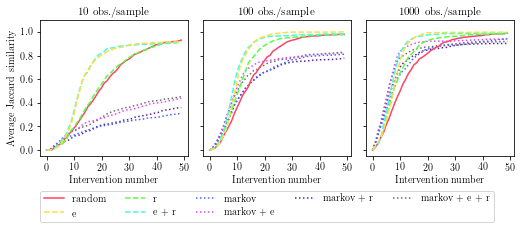

In [15]:
# Plot settings
gs = gridspec.GridSpec(1, 3, wspace=0.10, hspace=0.2)
plt.figure(figsize=(8.5,2.5))

plot_iter = 50
x_axis = np.arange(0, plot_iter)
ylim = [-0.05, 1.1]
linestyle = ['-', '--', '--', '--', ':', ':', ':', ':']
zorder = [1,4,2,3,-1,-2,-3,-4,-5]

##############################
# Plot trajectories for n=10
jac_sim10 = np.ones((P, N*runs, max_iter+1))
for i, trajectories in enumerate(Trajectories[0].values()):
    for j, trajectory in enumerate(trajectories):
        jac_sim10[i, j, 0:len(trajectory)] = trajectory
mean10 = np.mean(jac_sim10[:, :, :], axis=1)

plt.subplot(gs[0])
ax = plt.gca()
for i,name in enumerate(names):
    ax.plot(x_axis, mean10[i,x_axis], label=name, linewidth=1.5, linestyle = linestyle[i], color=colors[i], zorder=zorder[i])
plt.xlabel("Intervention number")
plt.ylabel("Average Jaccard similarity")
#plt.ylabel("True positive recovery")
ax.set_xticks(np.arange(0, plot_iter+1, 10))
ax.text(0.5,1.04,"10 obs./sample", transform=ax.transAxes, fontsize=11, ha="center")
plt.ylim(ylim)

##############################
# Plot trajectories for n=100
jac_sim100 = np.ones((P, N*runs, max_iter+1))
for i, (name, trajectories) in enumerate(Trajectories[1].items()):
    for j, trajectory in enumerate(trajectories):
        jac_sim100[i, j, 0:len(trajectory)] = trajectory
mean100 = np.mean(jac_sim100[:, :, :], axis=1)
plt.subplot(gs[1])
ax = plt.gca()
for i,name in enumerate(names):
    ax.plot(x_axis, mean100[i,x_axis], label=name, linewidth=1.5, linestyle = linestyle[i], color=colors[i], zorder=zorder[i])
plt.xlabel("Intervention number")
ax.set_yticklabels([])
ax.set_xticks(np.arange(0, plot_iter+1, 10))
ax.text(0.5,1.04,"100 obs./sample", transform=ax.transAxes, fontsize=11, ha="center")
plt.ylim(ylim)

##############################
# Plot trajectories for n=1000
jac_sim1000 = np.ones((P, N*runs, max_iter+1))
for i, (name, trajectories) in enumerate(Trajectories[2].items()):
    for j, trajectory in enumerate(trajectories):
        jac_sim1000[i, j, 0:len(trajectory)] = trajectory
mean1000 = np.mean(jac_sim1000[:, :, :], axis=1)

plt.subplot(gs[2])
ax = plt.gca()
for i,name in enumerate(names):
    ax.plot(x_axis, mean1000[i,x_axis], label=name, linewidth=1.5, linestyle = linestyle[i], color=colors[i], zorder=zorder[i])
plt.xlabel("Intervention number")
ax.set_yticklabels([])
ax.set_xticks(np.arange(0, plot_iter+1, 10))
ax.text(0.5,1.04,"1000 obs./sample", transform=ax.transAxes, fontsize=11, ha="center")
plt.ylim(ylim)

ax.legend(prop=fontP, ncol=5, bbox_to_anchor=(0.9, -.22))
plt.savefig('figures/tpr_finite_50_iter.pdf', bbox_inches='tight')

### Plot X: Policies that ran out of intervention targets

In [ ]:
len(EmptyPoolEvents[0]["random"])

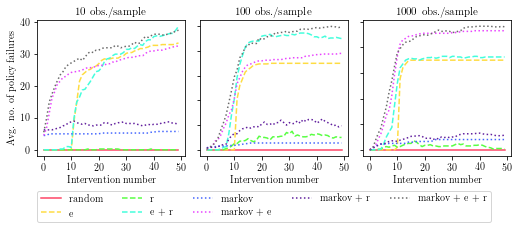

In [23]:
gs = gridspec.GridSpec(1, 3, wspace=0.10, hspace=0.2)
plt.figure(figsize=(8.5,2.5))

n = [10,100,1000]
ylim = [-0.05, 1.1]
linestyle = ['-', '--', '--', '--', ':', ':', ':', ':']
zorder = [1,4,2,3,-1,-2,-3,-4,-5]

for j in range(3):
    plt.subplot(gs[j])
    ax = plt.gca()
    # Compute and plot event numbers for each policy
    for i, (name, events_list) in enumerate(EmptyPoolEvents[j].items()):
        event_count = np.zeros(max_iter)
        for events in events_list:        
            event_count[events] += 1
        event_count /= runs
        ax.plot(event_count, label=name, color=colors[i], linewidth=1.5, linestyle = linestyle[i])
    # Plotting details
    plt.xlabel("Intervention number")
    plt.ylabel("Avg. no. of policy failures") if j==0 else None
    ax.set_yticklabels([]) if j != 0 else None
    ax.set_xticks(np.arange(0, max_iter+1, 10))
    ax.text(0.5,1.04,"%d obs./sample" % n[j], transform=ax.transAxes, fontsize=11, ha="center")
    
ax.legend(prop=fontP, ncol=5, bbox_to_anchor=(0.9, -.22))
plt.savefig('figures/empty_pool.pdf', bbox_inches='tight')

### Plot Y1: For given iterations, plot av. Jaccard similarity vs. av. no. of policy failures:

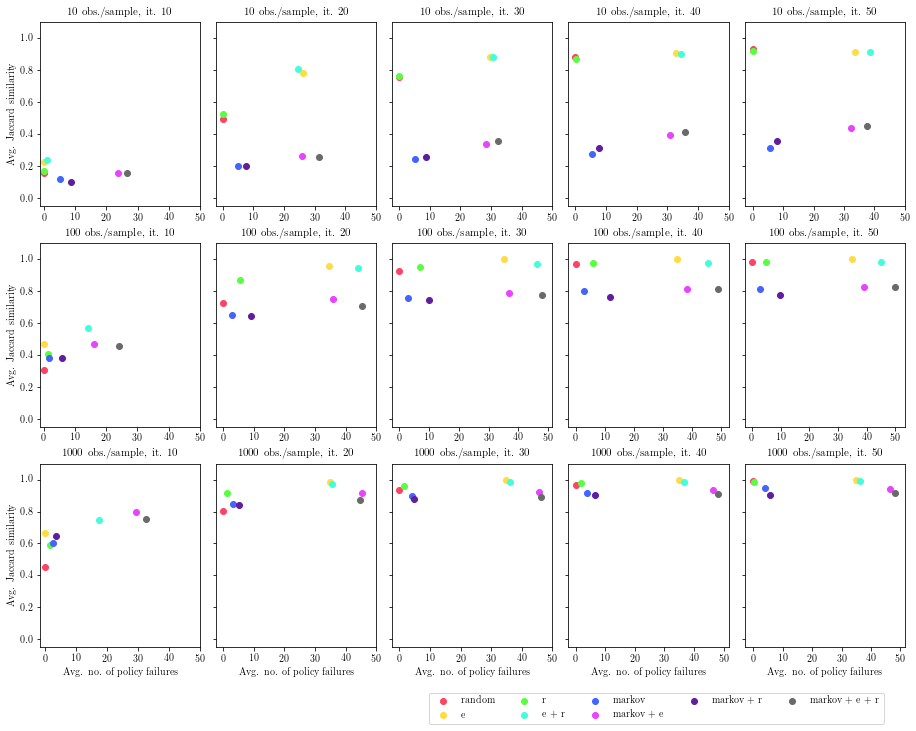

In [17]:
# Plot settings
gs = gridspec.GridSpec(3, 5, wspace=0.10, hspace=0.2)
plt.figure(figsize=(15.5,11.5))

plot_iter = 50
x_axis = np.arange(0, plot_iter)
ylim = [-0.05, 1.1]

##############################
sample_sizes = [10,100,1000]
it_nums = [10, 20, 30, 40, 50]

for k, n in enumerate(sample_sizes):
    jac_sim = np.ones((P, N*runs, max_iter+1))
    for i, trajectories in enumerate(Trajectories[k].values()):
        for j, trajectory in enumerate(trajectories):
            jac_sim[i, j, :] = trajectory
    mean_jac = np.mean(jac_sim[:, :, :], axis=1)

    for j, it_num in enumerate(it_nums):
        # For a given intervention number, plot policy failure against Jaccard sim
        plt.subplot(gs[k,j])
        ax = plt.gca()
        # Compute and plot event numbers for each policy
        for i, (name, events_list) in enumerate(EmptyPoolEvents[k].items()):
            event_count = np.zeros(max_iter)
            for events in events_list:        
                event_count[events] += 1
            event_count /= runs
            ax.scatter(event_count[it_num-1], mean_jac[i, it_num-1], label=name, color=colors[i])
        # Plotting details
        plt.xlabel("Avg. no. of policy failures") if k==2 else None
        plt.ylabel("Avg. Jaccard similarity") if j==0 else None
        ax.set_yticklabels([]) if j!=0 else None
        ax.set_xticks(np.arange(0, max_iter+1, 10))
        ax.text(0.5,1.04,"%d obs./sample, it. %d" % (sample_sizes[k], it_num), transform=ax.transAxes, fontsize=11, ha="center")
        plt.ylim(ylim)

ax.legend(prop=fontP, ncol=5, bbox_to_anchor=(0.9, -.22))
plt.savefig('figures/jac_vs_empty_pool.pdf', bbox_inches='tight')

### Plot Y2: For given iterations, plot av. Jaccard similarity vs. av. no. of policy failures:

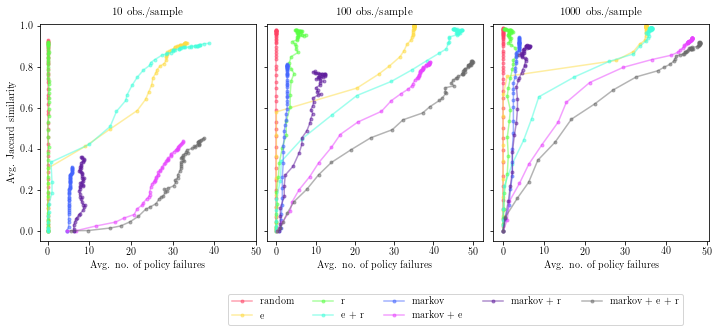

In [18]:
# Plot settings
gs = gridspec.GridSpec(1, 3, wspace=0.05, hspace=0.2)
plt.figure(figsize=(12,4))


plot_iter = 50
x_axis = np.arange(0, plot_iter)
ylim = [-0.05, 1.01]

##############################
sample_sizes = [10,100,1000]
it_nums = [10, 20, 30, 40, 50]

for k, n in enumerate(sample_sizes):
    plt.subplot(gs[k])
    ax = plt.gca()
    # Compute mean jaccard similarity vs. iter number for all policies
    jac_sim = np.ones((P, N*runs, max_iter+1))
    for i, trajectories in enumerate(Trajectories[k].values()):
        for j, trajectory in enumerate(trajectories):
            jac_sim[i, j, :] = trajectory
    mean_jac = np.mean(jac_sim[:, :, :], axis=1)
    
    for i, (name, events_list) in enumerate(EmptyPoolEvents[k].items()):
        # Compute avg. numner of policy failures for each policy
        event_count = np.zeros(max_iter)
        for events in events_list:        
            event_count[events] += 1
        event_count /= runs
        # Plot jac. sim vs. avg. policy failures
        ax.plot(event_count[0:max_iter], mean_jac[i, 0:max_iter], marker='.', label=name, color=colorsa[i])
    
    # Axis labels
    ax.set_xticks(np.arange(0, max_iter+1, 10))
    plt.xlabel("Avg. no. of policy failures")
    plt.ylabel("Avg. Jaccard similarity") if k==0 else None
    ax.set_yticklabels([]) if k!=0 else None
    ax.text(0.5,1.04,"%d obs./sample" % sample_sizes[k], transform=ax.transAxes, fontsize=11, ha="center")
    plt.ylim(ylim)

ax.legend(prop=fontP, ncol=5, bbox_to_anchor=(0.9, -.22))
plt.savefig('figures/jac_vs_empty_pool_trajectory.pdf', bbox_inches='tight')

### Plot Z: For each iteration, plot av. no. of policy failures when Jaccard similarity is not 1:

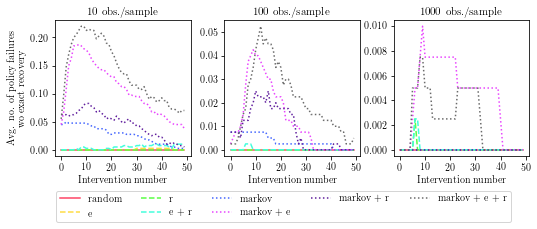

In [22]:
sample_sizes = [10,100,1000]

# Compute avg. number of policy failures, per iteration, when jaccard sim is not 1
it_nums = list(range(max_iter))
jac_sim_ep = np.zeros((len(sample_sizes), P, N*runs, len(it_nums)))
for k, n in enumerate(sample_sizes):
    # get empty pool events and trajectories for each sample size
    empty_pool_events = EmptyPoolEvents[k]
    trajectories = Trajectories[k]
    # get empty pool events and trajectories for each policy
    for i, (name, events_list) in enumerate(empty_pool_events.items()):
        empty_pool_events_p = empty_pool_events[name]
        trajectory_p = trajectories[name]
        # For a given intervention number, is the pool empty while Jaccard sim is not 1?
        for ii in range(N*runs):
            for j, it_num in enumerate(it_nums):
                if it_num in empty_pool_events_p[ii] and trajectory_p[ii][it_num] != 1:
                    jac_sim_ep[k, i, ii, j] = 1

mean_jac_sim_ep = np.mean(jac_sim_ep[:, :, :, :], axis=2)

# Plot settings
gs = gridspec.GridSpec(1, 3, wspace=0.25, hspace=0.2)
plt.figure(figsize=(8.5,2.5))

x_axis = np.arange(0, max_iter)
ylim = [0, 0.05]
linestyle = ['-', '--', '--', '--', ':', ':', ':', ':']

# Plot
for j, n in enumerate(sample_sizes):
    plt.subplot(gs[j])
    ax = plt.gca()
    # Compute and plot event numbers for each policy
    for i, (name, events_list) in enumerate(EmptyPoolEvents[j].items()):
        ax.plot(mean_jac_sim_ep[j, i, :], label=name, color=colors[i], linewidth=1.5, linestyle = linestyle[i])
    # Plotting details
    plt.xlabel("Intervention number")
    plt.ylabel("Avg. no. of policy failures\nwo exact recovery") if j==0 else None
    #ax.set_yticklabels([]) if j != 0 else None
    ax.set_xticks(np.arange(0, max_iter+1, 10))
    ax.text(0.5,1.04,"%d obs./sample" % sample_sizes[j], transform=ax.transAxes, fontsize=11, ha="center")
    
ax.legend(prop=fontP, ncol=5, bbox_to_anchor=(0.9, -.22))
plt.savefig('figures/empty_pool_Jacc_not1.pdf', bbox_inches='tight')